# ⭐AIFFEL 대전1기 Exploration 8. 아이유 팬이 좋아할 만한 다른 아티스트 찾기⭐
> 프로젝트 소개: 추천 시스템을 이용해 내가 좋아하는 아티스트(영화)와 관련된 다른 아티스트(영화)를 추천 받아보기

***

# 🎯프로젝트 목표
- ### 영화 데이터를 활용해 Matrix Factorization, CSR Matrix을 제작
- ### 내가 선호하는 영화 데이터를 추가해 영화 추천 모델 생성
- ### 내 id기반으로 영화 추천 받아보기
- ### 임의의 영화와 비슷한 영화 추천 받아보기

***

# 🎬프로젝트 순서

## 0. 개념 정리

## 1. 데이터 준비와 전처리
### 1-1. 평점 데이터 불러오기
### 1-2. 평점 3점 이상만 추출
### 1-3. 컬럼 이름 변경(rating -> count)
### 1-4. 영화 데이터 불러오기
### 1-5. 사용하지 않은 컬럼 저장 후 데이터 프레임에서 삭제

## 2. 데이터 분석
### 2-1. 영화 제목 <-> movie_id 알아내는 딕셔너리 생성
### 2-2. 유니크한 영화, 사용자 수
### 2-3. 가장 인기 있는 영화 30개(인기순)
### 2-4. 평점이 높은 영화 30개

## 3. 내가 선호하는 영화를 5가지 골라서 rating에 추가
### 3-1. 내가 선호하는 영화 찾기
### 3-2. 내 아이디 및 영화 데이터 ratings에 추가¶

## 4. CSR matrix 제작

## 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련
### 5-1. AlternatingLeastSquares 모델 설계
### 5-2. 모델 훈련

## 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 훈련된 모델이 예측한 나의 선호도를 파악
### 6-1. 나의 벡터와 선호 영화 벡터 생성 및 dot product
### 6-2. 다른 영화와의 내적값 비교

## 7. 내가 좋아하는 영화와 비슷한 영화를 추천받기

## 8. 내가 가장 좋아할 만한 영화들을 추천받기
### 8-1. als_model을 이용해 추천 리스트 만들기
### 8-2. 추천한 영화가 왜 나왔는지 추천 기여도 파악

## 9. 회고
### 9-1. 루브릭 평가
### 9-2. 회고

***

## 0. 개념정리

### 1. 추천 시스템?
- 사용자가 선호할 만한 아이템을 추측함으로써 여러 가지 항목 중 사용자에게 적합한 특정 항목을 선택(information filtering)하여 제공하는 시스템 

### 2. 고전척 추천 시스템 - 출처: http://www.kocca.kr/insight/vol05/vol05_04.pdf
#### 1) 협업 필터링
- 대규모의 기존 사용자 행동 정보를 분석하여 해당 사용자와 비슷한 성향의 사용자들이 기존에 좋아했던 항목을 추천하는 기술
- 예시: '이 상품을 구매한 사용자가 구매한 상품들' - 라면을 구매한 소비자가는 생수를 많이 구입 --> 라면을 산 고객에게 생수를 추천
- 장점: **직관적, 항목의 구체적은 분석이 필요없다** (라면과 생수가 식품인지 같이 사용되는 물품인지 분석할 필요가 없다)
        또한 용자들이 자연스럽게 사이트를 사용하면서 검색을 하고, 항목을 보고, 구매한 내역을 사용할 수 있다.
- 단점: **콜드 스타트(Cold start) - ‘새로 시작할 때 곤란함**
       계산량이 비교적 많은 알고리즘이므로 사용자 수가 많은 경우 효율적으로 추천할 수 없다.
       **롱테일(Long-tail) - 시스템 항목이 많다 하더라도 사용자들은 소수의 인기 있는 항목에만 관심을 보이기 때문에 정보의 비대칭적 쏠림**
- 핵심 기술:  비슷한 패턴을 가진 사용자나 항목을 추출하는 기술(행렬분해(Matrix Factorization), k-최근접 이웃 알고리즘 (k-Nearest Neighbor algorithm; kNN) 등의 방법 등)  

#### 2) 콘텐츠 기반 필터링
- 항목 자체를 분석하여 추천을 구현
- 항목을 분석한 프로파일(item profile)과 사용자의 선호도를 추출한 프로파일(user profile)을 추출하여 이의 유사성을 계산
**예시: 음원 사이트 판도라 - 신곡이 출시되면 음악을 분석하여 장르, 비트, 음색 등 약 400여 항목의 특성을 추출한다. 그리고 사용자로부터는 ‘like’를 받은 음악의 특색을 바탕으로 해당 사용자의 프로파일을 준비**
- 핵심: 콘텐츠의 내용을 분석해야 하므로 아이템 분석 알고리즘 / 군집분석(Clustering analysis), 인공신경망(Artificial neural network), tf-idf(term frequency-inverse document frequency)\
- 장점: 내용 자체를 분석하므로 협업 필터링에서 발생하는 콜드 스타트 문제를 자연스럽게 해결
- 단점: 다양한 형식의 항목을 추천하기 어려운 단점

### 3. Explict Dataset VS Implict Dataset (추천 시스템의 데이터셋 구축)
#### 1) Explict Dataset(명시적 데이터셋)
- 유저가 자신의 선호도를 직접(Explict) 표현한 Data
- 좋아요, 싫어요, 리뷰, 구독, 차단 등
- 장점: 유저의 호불호를 정확히 판단 가능
- 단점: 데이터를 얻기 힘들다. (유저들의 자발적인 참여가 필요함)

#### 2) Implict Dataset(암묵적 데이터셋)
- 유저가 간접적(Implice)으로 선호, 취향을 나타내는 Data
- 검색 기록, 방문 페이지, 구매 내역, 마우스 움직임 등
- 장점:수집 난이도가 낮고 활용할 수 있는 데이터가 다양하다
- 특징  
 1) 수집되지 않은 데이터도 모델링해야한다. (부정적인 정보가 포함되어 있을 수 있다.  
 2) 데이터에 잡음이 많다. (실제 영화를 끝까지 시청했다하더라도 좋아서 본 것인지 과제때문인지 선호도를 정확히 파악할 수 없다)  
 3) Explict Dataset에서는 시청시간과 선호도는 비례하지만 Implict Dataset에서는 꼭 그렇지는 않다. 하지만 그럼에도 수치와 선호도는 비례  
 4) item의 availability나 반복되는 feeback 등을 고려  
  - availability: 동시간에 방영되는 두 TV Show의 경우 한쪽만 볼 수 있어서 다른 프로그램을 좋아한다고 해도 Implicit Data가 쌓이지 않는 상황  
  - 반복되는 Feedback은 유저가 한 번 이상 프로그램을 봤을 때 한 번 본 경우와 어떻게 다르게 평가할 것인가에 대한 고려

### 4. Matrix Factorization(MF)
- 2006년 Netflix에서 개최한 추천시스템 챌린지를 통해 알려지게 되었다. (성능 10% 향상)
- (m,n) 사이즈의 행렬 R을 (m,k) 사이즈의 행렬 P와 (k,n) 사이즈의 행렬 Q로 분해한다면 R이란 그저 P와 Q의 행렬곱으로 표현 가능할 수 있다
- 아이디어의 단순함에도 불구하고 MF 모델은 성능이 준수하고 Scalability가 좋아서 많이 사용되는 모델
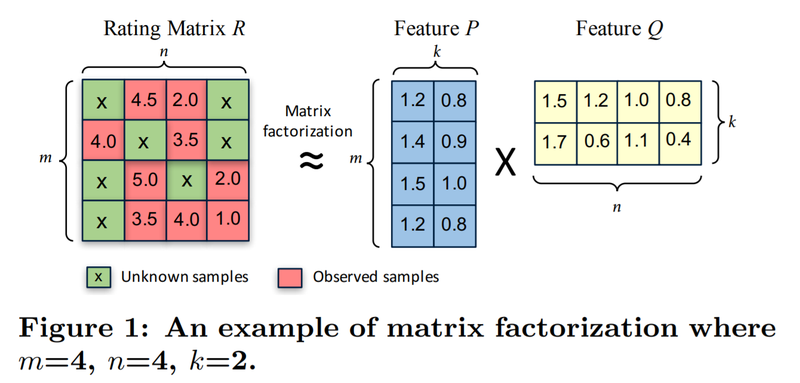
[- 출처: CuMF_SGD: Fast and Scalable Matrix Factorization(https://arxiv.org/pdf/1610.05838.pdf)]
  
  
  
- MF 모델은 큰 평가행렬R을 두 개의 Feature Matrix P와 Q로 분해
- 평가행렬 크기가 (m,n)일 때 P는 (m,k)크기의 Feature Matrix로 표현된다.
- 아래 그림에서 첫 번째 벡터 P0=(1, 0.1)은 빨간 모자를 쓴 **첫 번째 사용자 특성(Feature)벡터**
- 같은 방식으로 Q의 첫 번째 벡터 Q0(0.9, -0.2)는 **해리포터 영화의 특성 벡터**.
- 즉, MF모델은 P, Q 두 벡터를 내적한 결과로 표현
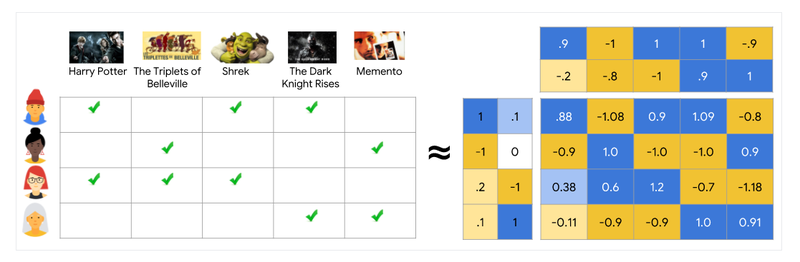
[출처: https://developers.google.com/machine-learning/recommendation/collaborative/matrix]

### 5. CSR(Compressed Sparse Row) Matrix
- MF는 평가행렬을 생성하는데 평가행렬을 생성할 때 너무 많은 행과 열 개수로 인해 메모리가 부족하고 성능이 떨어질 수 있다.
- Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조
- 즉, Sparse(수학에서는 대부분이 0으로 나타내진다)한 행을 압축해 불필요한 내용을 줄여 성능을 올릴 수 있다.
  
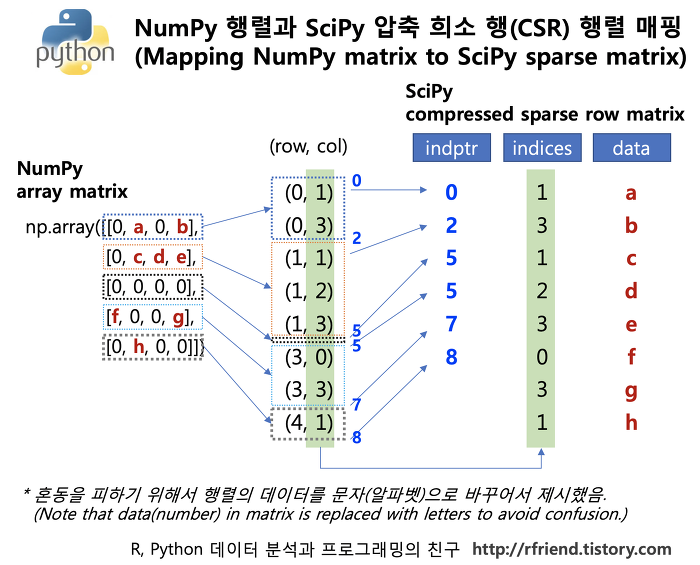
> 출처: https://rfriend.tistory.com/551

예시) 코드로 구현해보기
~~~
import numpy as np
from scipy.sparse import csr_matrix

data = np.array([1, 2, 3, 4, 5, 6, 7, 8])
row = np.array([0, 0, 1, 1, 1, 3, 3, 4])
col = np.array([1, 3, 1, 2, 3, 0, 3, 1])

csr_mat3 = csr_matrix((data, (row, col)), shape=(5, 4))

print('data:', csr_mat3.data)        # data: [1 2 3 4 5 6 7 8]
print('indptr:', csr_mat3.indptr)    # indptr: [0 2 5 5 7 8] 
print('indices:', csr_mat3.indices)  # indices: [1 3 1 2 3 0 3 1]

print(csr_mat3)
  # (0, 1)	1
  # (0, 3)	2
  # (1, 1)	3
  # (1, 2)	4
  # (1, 3)	5
  # (3, 0)	6
  # (3, 3)	7
  # (4, 1)	8
~~~

위의 코드는 data = [1,2,3,4,5,6,7,8]를 CSR 행렬(형태=(5,4))로 변형해라 (행=[0,0,1,1,1,3,3,4], 열=[1,3,1,2,3,0,3,1])  
data안의 인자는 새로운 행과 열 번호를 받아 재배치되며 비어있는 값은 0으로 처리한다.  
1은 (0,1)  
2는 (0,3)  
3은 (1,1)  
4는 (1,2)  
5는 (1,3)  
6은 (3,0)  
7은 (3,3)  
8은 (4,1)  
이겨서 2행에는 어떤 값도 할당되지 않아 모두 0이 된다.  

재배열한 행렬은 아래와 같다.  

[[0,1,0,2,0],  
 [0,3,4,5,0],  
 [0,0,0,0,0],  
 [6,0,0,7,0],  
 [0,8,0,0,0]]  
 
indptr은 '행을 기준으로 했을 때 행별로 '0'이 아닌 원소가 처음 시작하는 위치의 배열'이므로 아래와 같이 구할 수 있다.  

row col  
----------0  
 0   1  
 0   3  
----------2   
 1   1  
 1   2  
 1   3  
----------5  
----------5  
 3   0  
 3   3  
----------7   
 4   1  
----------8  

위 그림과 같이 [0,2,5,5,7,8]로 나온 것을 알 수 있다. (코드 결과와 동일)
여기서 2행은 모두 0이기 때문에 5가 반복되었다.

### 6. MF 모델 학습하기
- implicit 패키지를 사용하여 학습
- implicit 패키지: 이전 스텝에서 설명한 암묵적(implicit) dataset을 사용하는 다양한 모델을 굉장히 빠르게 학습할 수 있는 패키지
- als(AlternatingLeastSquares) 모델을 사용
- 두 개로 쪼개진 행렬(위에서 언급한 P와 Q 행렬) 중 하나를 고정하고 다른쪽을 학습하는 방식을 번갈아 수행하는 AlternatingLeastSquares 방식이 효과적
  
  
 <AlternatingLeastSquares 클래스의 __init__ 파라미터>
1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지  
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지  
3. use_gpu : GPU를 사용할 것인지  
4. iterations : epochs와 같은 의미



***

# 1. 데이터 준비와 전처리

## 1-1. 평점 데이터 불러오기

In [39]:
import os
import pandas as pd
rating_file_path=os.getenv('HOME') + '/1.AIFFEL_Study/Exploration/E08_Recommendation_System/data/ml-1m/ratings.dat'
ratings_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names=ratings_cols, engine='python')
orginal_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


## 1-2. 평점 3점 이상만 추출

In [2]:
# 3점 이상만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'orginal_data_size: {orginal_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining Data is {filtered_data_size / orginal_data_size:.2%}')

orginal_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining Data is 83.63%


## 1-3. 컬럼 이름 변경(rating -> count)

In [3]:
# rating 컬럼의 이름을 count로 바꿉니다.
ratings.rename(columns={'rating':'count'}, inplace=True)
ratings['count']

0          5
1          3
2          3
3          4
4          5
          ..
1000203    3
1000205    5
1000206    5
1000207    4
1000208    4
Name: count, Length: 836478, dtype: int64

## 1-4. 영화 데이터 불러오기

In [4]:
# 영화 제목을 보기 위해 메타 데이터를 읽어옵니다.
movie_file_path=os.getenv('HOME') + '/1.AIFFEL_Study/Exploration/E08_Recommendation_System/data/ml-1m/movies.dat'
cols = ['movie_id', 'title', 'genre'] 
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python')
movies.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## 1-5. 사용하지 않는 컬럼 저장 후 데이터 프레임에서 삭제

In [5]:
# timestamp 따로 저장, ratings에서 삭제
timestamp = ratings['timestamp']
del ratings['timestamp']

# genre 따로 저장, movies에서 삭제
genre = movies['genre']
del movies['genre']

In [37]:
ratings.head(5)

,user_id,movie_id,count
0,1,1193,5
1,2339,1952,5
2,4671,1210,5
3,2340,715,5
4,2340,2987,5


In [38]:
movies.head(5)

,movie_id,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


***

# 2. 데이터 분석

## 2-1. 영화 제목 <-> movie_id 알아내는 딕셔너리 생성

In [6]:
# movie_id를 가지고 영화 제목 알아내기
# 영화 제목으로 movie_id 찾기

idx_to_movie = {}
movie_to_idx = {}

for i in range(movies.shape[0]):
    idx_to_movie[movies['movie_id'][i]] = movies['title'][i]
    movie_to_idx[movies['title'][i]] = movies['movie_id'][i]

print(idx_to_movie[300])
print(movie_to_idx['Quiz Show (1994)'])

Quiz Show (1994)
300


In [7]:
# movie_id == 300 확인. 일치!

movies[movies['movie_id']==300]

,movie_id,title
297,300,Quiz Show (1994)


In [8]:
# title == 'Quiz Show (1994)' 확인. 일치!

movies[movies['title']=='Quiz Show (1994)']

,movie_id,title
297,300,Quiz Show (1994)


## 2-2. 유니크한 영화, 사용자 수
**ratings에 있는 유니크한 영화 개수**  
**rating에 있는 유니크한 사용자 수**

In [9]:
# ratings에 있는 유니크한 영화 개수
print('유니크한 영화 개수는 :', ratings['movie_id'].nunique(), '개')

# rating에 있는 유니크한 사용자 수
print('유니크한 사용자 수는 :', ratings['user_id'].nunique(), '명')

유니크한 영화 개수는 : 3628 개
유니크한 사용자 수는 : 6039 명


## 2-3. 가장 인기 있는 영화 30개(인기순)
- raings 데이터 프레임에서 하나의 movide_id에 얼마나 많은 user_id가 있는 구하기 (**groupby**)

In [10]:
# ratings 데이터 프레임에서 하나의 movie_id에 얼마나 많은 user_id가 있는지 합계 구한뒤
# 내림차순으로 정렬해서 30개만 보여주기

grouped = ratings['user_id'].groupby(ratings['movie_id']).sum()
top_30_movies_id = grouped.sort_values(ascending=False)[:30]
for i in range(len(top_30_movies_id)):
    print('가장 인기있는 {}순위 영화는: {}'.format(i+1, idx_to_movie[top_30_movies_id.index[i]]))

가장 인기있는 1순위 영화는: American Beauty (1999)
가장 인기있는 2순위 영화는: Star Wars: Episode IV - A New Hope (1977)
가장 인기있는 3순위 영화는: Star Wars: Episode V - The Empire Strikes Back (1980)
가장 인기있는 4순위 영화는: Star Wars: Episode VI - Return of the Jedi (1983)
가장 인기있는 5순위 영화는: Back to the Future (1985)
가장 인기있는 6순위 영화는: Saving Private Ryan (1998)
가장 인기있는 7순위 영화는: Silence of the Lambs, The (1991)
가장 인기있는 8순위 영화는: Raiders of the Lost Ark (1981)
가장 인기있는 9순위 영화는: Sixth Sense, The (1999)
가장 인기있는 10순위 영화는: Terminator 2: Judgment Day (1991)
가장 인기있는 11순위 영화는: Matrix, The (1999)
가장 인기있는 12순위 영화는: Fargo (1996)
가장 인기있는 13순위 영화는: Princess Bride, The (1987)
가장 인기있는 14순위 영화는: Jurassic Park (1993)
가장 인기있는 15순위 영화는: Godfather, The (1972)
가장 인기있는 16순위 영화는: Schindler's List (1993)
가장 인기있는 17순위 영화는: Men in Black (1997)
가장 인기있는 18순위 영화는: Shakespeare in Love (1998)
가장 인기있는 19순위 영화는: Shawshank Redemption, The (1994)
가장 인기있는 20순위 영화는: L.A. Confidential (1997)
가장 인기있는 21순위 영화는: Braveheart (1995)
가장 인기있는 22순위 영화는: E.T. the Extra-Terre

## 2-4. 평점이 높은 영화 30개
- 평점 순으로 내림차순 정렬 후 30개만 추출 (엄밀히 말하면 5점끼리는 비교가 안 되어서 순위가 의미가 없지만 **정렬에 대한 문법을 익히기 위해 사용**)

In [11]:
# 평점 기준으로 내림차순

ratings.sort_values(by=['count'], axis=0, ascending=False, inplace=True)
ratings.reset_index(drop=True, inplace=True)
ratings.head(10)

,user_id,movie_id,count
0,1,1193,5
1,2339,1952,5
2,4671,1210,5
3,2340,715,5
4,2340,2987,5
5,4671,380,5
6,1293,524,5
7,1293,527,5
8,2339,3929,5
9,2339,3922,5


In [12]:
# 평점이 높은 영화 30개

for i in range(30):
    print('가장 평점이 높은 영화 {}순위는 : {}'.format(i+1, movies[movies['movie_id'] == ratings.loc[i,'movie_id']].iloc[0,1]))

가장 평점이 높은 영화 1순위는 : One Flew Over the Cuckoo's Nest (1975)
가장 평점이 높은 영화 2순위는 : Midnight Cowboy (1969)
가장 평점이 높은 영화 3순위는 : Star Wars: Episode VI - Return of the Jedi (1983)
가장 평점이 높은 영화 4순위는 : Horseman on the Roof, The (Hussard sur le toit, Le) (1995)
가장 평점이 높은 영화 5순위는 : Who Framed Roger Rabbit? (1988)
가장 평점이 높은 영화 6순위는 : True Lies (1994)
가장 평점이 높은 영화 7순위는 : Rudy (1993)
가장 평점이 높은 영화 8순위는 : Schindler's List (1993)
가장 평점이 높은 영화 9순위는 : Bank Dick, The (1940)
가장 평점이 높은 영화 10순위는 : Bikini Beach (1964)
가장 평점이 높은 영화 11순위는 : Beach Party (1963)
가장 평점이 높은 영화 12순위는 : Fish Called Wanda, A (1988)
가장 평점이 높은 영화 13순위는 : Best in Show (2000)
가장 평점이 높은 영화 14순위는 : Phantom of the Opera, The (1943)
가장 평점이 높은 영화 15순위는 : Duck Soup (1933)
가장 평점이 높은 영화 16순위는 : Being John Malkovich (1999)
가장 평점이 높은 영화 17순위는 : Dirty Dancing (1987)
가장 평점이 높은 영화 18순위는 : Godfather: Part II, The (1974)
가장 평점이 높은 영화 19순위는 : Sleepless in Seattle (1993)
가장 평점이 높은 영화 20순위는 : Toy Story (1995)
가장 평점이 높은 영화 21순위는 : Lethal Weapon 4 (1998)
가장 평점

***

# 3. 내가 선호하는 영화를 5가지 골라서 rating에 추가

**내 user_id = 6041 (기존 user_id 최대값 + 1)**  
**내가 선호하는 영화 = Star Wars, Star Trek 시리즈**

## 3-1. 내가 선호하는 영화 찾기
- **Star Wars, Star Trek** 시리즈

In [13]:
# Star Wars, Star Trek 영화 찾기

for i in range(movies.shape[0]):
    if movies.iloc[i,1][:9] == 'Star Wars':
        print(movies.iloc[i,1])
    elif movies.iloc[i,1][:9] == 'Star Trek':
        print(movies.iloc[i,1])        

Star Wars: Episode IV - A New Hope (1977)
Star Trek: Generations (1994)
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Star Trek: First Contact (1996)
Star Trek: The Motion Picture (1979)
Star Trek VI: The Undiscovered Country (1991)
Star Trek V: The Final Frontier (1989)
Star Trek: The Wrath of Khan (1982)
Star Trek III: The Search for Spock (1984)
Star Trek IV: The Voyage Home (1986)
Star Trek: Insurrection (1998)
Star Wars: Episode I - The Phantom Menace (1999)


In [14]:
# 선호하는 영화 5개 리스트

my_favorite_title = ['Star Wars: Episode IV - A New Hope (1977)', 
               'Star Wars: Episode V - The Empire Strikes Back (1980)', 
               'Star Wars: Episode VI - Return of the Jedi (1983)',
              'Star Trek: Generations (1994)',
              'Star Trek: Insurrection (1998)']

# 선호하는 영화 movie_id 리스트 생성
my_favorite_id = []
for i in range(movies.shape[0]):
    if movies.iloc[i,1] in my_favorite_title:
        my_favorite_id.append(movies.iloc[i,0])

print(my_favorite_id)

[260, 329, 1196, 1210, 2393]


## 3-2. 내 아이디 및 영화 데이터 ratings에 추가

**내가 사용할 user_id 확인하기**
- 기존 user_id보다 1이 큰 값을 사용 = 6041

In [40]:
# 내 user_id = 기존 최대값 +1 = 6041

print(ratings['user_id'].max()) # 6040

6040


**내 아이디 및 영화 데이터 추가**

In [16]:
# user_id == 6041가 위 영화를 5번 봤다고 가정

my_playlist = pd.DataFrame({'user_id':[6041]*5, 'movie_id':my_favorite_id, 'count' : [5]*5 })

if not ratings.isin({'user_id':[6041]})['user_id'].any():
    ratings = ratings.append(my_playlist)
    print('추가!')
ratings[ratings['user_id'] == 6041]

추가!


,user_id,movie_id,count
0,6041,260,5
1,6041,329,5
2,6041,1196,5
3,6041,1210,5
4,6041,2393,5


In [17]:
ratings.reset_index(drop=False, inplace=True) # 인덱스 번호 초기화
ratings.drop('index', axis=1, inplace=True) # 'index' 컬럼 삭제
ratings.tail(10)

,user_id,movie_id,count
836473,4194,661,3
836474,1727,2581,3
836475,1727,174,3
836476,4194,1885,3
836477,3080,3536,3
836478,6041,260,5
836479,6041,329,5
836480,6041,1196,5
836481,6041,1210,5
836482,6041,2393,5


***

# 4. CSR matrix 제작
- `scipy.sparse`의 `csr_matrix` 이용

In [18]:
# 실습 위에 설명보고 이해해서 만들어보기
from scipy.sparse import csr_matrix

num_user = ratings['user_id'].nunique()
num_movie = ratings['movie_id'].nunique()
# csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)), shape= (num_user, num_movie))
csr_data = csr_matrix((ratings['count'], (ratings.user_id, ratings.movie_id)))
csr_data

<6042x3953 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Row format>

In [19]:
# 수치 확인

print(num_user)
print(num_movie)
print(csr_data.shape)

6040
3628
(6042, 3953)


### 오류 해결
**오류1 TypeError: len() of unsized object**  
\>> ratings.count는 data type이 method이다.  
\>> ratings.count -> ratings[\'count\'] 변경

**오류2 ValueError: row index exceeds matrix dimensions**  
\>> shape이 맞지 않는 것으로 판단하고 shape = (num_user, num_movie) 삭제  
\>> 입력크기 < 출력크기가 되면 오류가 발생, 아마 큰 행렬을 압축을 해야하는데 예를 들어 100\*100 행렬을 300\*300으로 압축을 못하는 것과 같다고 생각함

***

# 5. als_model = AlternatingLeastSquares 모델을 직접 구성하여 훈련

## 5-1. AlternatingLeastSquares 모델 설계
- Matrix Factorization에서 쪼개진 두 Feature Matrix를 한쪽을 고정시키고 다른 쪽을 학습하는 방식을 번갈아 수행하는 `AlternatingLeastSquares` 방식 사용

In [20]:
from implicit.als import AlternatingLeastSquares
import os
import numpy as np

In [21]:
# Implicit AlternatingLeastSquares 모델의 선언

"""
아래 파라미터의 의미
1. factors : 유저와 아이템의 벡터를 몇 차원으로 할 것인지 
2. regularization : 과적합을 방지하기 위해 정규화 값을 얼마나 사용할 것인지
3. use_gpu : GPU를 사용할 것인지
4. iterations : epochs와 같은 의미

1,4를 늘릴수록 학습데이터를 잘 학습하게 되지만 과적합의 우려가 있으니 좋은 값을 찾아야 함
"""

als_model = AlternatingLeastSquares(factors=100, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [22]:
# als 모델은 input으로 (item X user 꼴의 matrix를 받기 때문에 Transpose해줍니다.)
csr_data_transpose = csr_data.T
csr_data_transpose

<3953x6042 sparse matrix of type '<class 'numpy.int64'>'
	with 836483 stored elements in Compressed Sparse Column format>

## 5-2. 모델 훈련

In [23]:
# 모델 훈련
als_model.fit(csr_data_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

***

# 6. 내가 선호하는 5가지 영화 중 하나와 그 외의 영화 하나를 골라 
# 훈련된 모델이 예측한 나의 선호도를 파악

## 6-1. 나의 벡터와 선호 영화 벡터 생성 및 dot product
- 내적값은 0.5이상이면 예측을 잘 했다고 판단
- 선호 영화 중 하나(**스타워즈 에피소드 4**) 선정!  

**>> 선호 영화 내적 결과: 0.74으로 높은 결과!!**  

  
- 선호 영화와 비슷한 영화인 **스타워즈 에피소드 1** 선정!!  
    
**>> 선호 영화와 비슷한 영화 내적 결과: 0.55으로 꽤 높은 결과!!**  


- 그 외의 영화는 **벅스라이프** 선정!

**>> 그 외의 영화 내적 결과: 0.01로 예상대로 낮게 나왔다!!**

In [24]:
changwon, Star_Wars_4 = 6041, movie_to_idx['Star Wars: Episode IV - A New Hope (1977)']
changwon_vector, Star_Wars_4_vector = als_model.user_factors[changwon], als_model.item_factors[Star_Wars_4]

print('슝=3')

슝=3


In [25]:
changwon_vector

array([-0.20363872,  0.68029785, -0.10822541,  0.86766464,  0.93114924,
       -0.4947468 , -0.07666354,  0.47083214, -0.7512083 ,  0.27251425,
        0.11556091,  1.0420107 ,  0.29394552,  0.4922162 ,  0.12158621,
        0.6859109 ,  0.16558836,  0.16997059, -0.50739706, -0.40584302,
        0.31050113, -0.10325591,  0.26326594,  0.837644  ,  0.53705984,
       -0.02887434, -0.7878739 ,  0.35122794,  0.32755876, -0.07013316,
        0.23607977,  0.21409976,  0.09024773,  0.248834  ,  0.4626536 ,
       -0.5684193 ,  0.6822976 , -0.09041742,  1.2106297 , -0.71523124,
       -0.6370963 , -0.39393854, -0.629036  ,  0.6099695 , -1.1634865 ,
        0.41152704, -1.2613839 , -0.541022  ,  0.2024764 ,  1.1063497 ,
        1.4076657 ,  0.0773906 , -0.8754707 , -0.69613296,  0.2557073 ,
       -0.03733326,  0.18821631,  0.7686676 , -0.19114166, -0.77741665,
       -0.3778547 , -0.603571  ,  0.48525915,  0.33819273, -0.20484309,
       -0.2342393 ,  0.73838645, -0.53400123, -0.8145822 , -0.31

In [26]:
Star_Wars_4_vector

array([ 4.43309499e-03, -1.41918834e-04, -4.68930090e-03,  2.87507921e-02,
        2.99330596e-02, -6.27196534e-03, -3.76823638e-03,  1.12597235e-02,
       -1.72621459e-02,  1.38055729e-02,  2.90000439e-02,  3.33172232e-02,
        1.00687100e-02,  3.71224582e-02,  1.84249133e-02,  2.73617823e-02,
        2.85439137e-02,  7.45969359e-03, -1.55254444e-02, -1.23542231e-02,
       -6.93001831e-03,  2.14200886e-03, -3.72399460e-04,  5.61804660e-02,
        8.36535636e-03,  1.25846779e-02,  6.43340498e-03,  2.33049896e-02,
        4.12115417e-02, -1.66173954e-03, -2.00007833e-03,  2.97679789e-02,
       -3.53423320e-03,  2.27970146e-02,  2.37008335e-05, -2.34697070e-02,
        1.84669700e-02,  1.82544384e-02,  6.93569556e-02, -4.13987972e-03,
       -1.44109074e-02,  4.01190622e-03, -3.22286189e-02, -4.68248222e-03,
       -1.71169825e-02,  1.29713640e-02, -2.47493554e-02, -2.29864363e-02,
        2.35689376e-02,  2.85571348e-02,  2.56235357e-02,  2.35489365e-02,
       -2.38285605e-02, -

In [27]:
# changwon, Star_Wars_4_vector 내적하는 코드
np.dot(changwon_vector, Star_Wars_4_vector) # 0.7495111

0.7495111

## 6-2. 다른 영화와의 내적값 비교
- '스타워즈 에피소드 1'은 0.55,  
- '벅스라이프'는 0.01  
 **선호 영화에 '스타워즈', '스타트랙' 시리즈를 추가했기 때문에 애니메이션인 '벅스라이프'는 매우 낮은 값이 나왔다!**

In [28]:
# Star Wars 에피소드 1과 내적 = 0.5492575

Star_Wars_1 = movie_to_idx['Star Wars: Episode I - The Phantom Menace (1999)']
Star_Wars_1_vector = als_model.item_factors[Star_Wars_1]
np.dot(changwon_vector, Star_Wars_1_vector) # 0.5492575

0.5599505

In [29]:
# Bugs_life 에피소드 1과 내적 = 0.028826598

Bugs_life = movie_to_idx['Bug\'s Life, A (1998)']
Bugs_life_vector = als_model.item_factors[Bugs_life]
np.dot(changwon_vector, Bugs_life_vector) # 0.028826598

0.015395731

***

# 7. 내가 좋아하는 영화와 비슷한 영화를 추천받기
## 사실 난 애니메이션을 좋아한다..!
- `AlternatingLeastSquares` 클래스에 구현되어 있는 `similar_items` 메서드를 통하여 비슷한 영화 찾기
- 이번엔 **'벅스라이프'** 영화와 비슷한 영화를 추천 받아보자!  

 **'토이스토리', '알라딘' 등 디즈니 애니메이션 영화가 많이 추천되었다!**

In [30]:
def get_similar_movie(movie_name: str):
    movie_id = movie_to_idx[movie_name]
    similar_movie = als_model.similar_items(movie_id)
    similar_movie = [idx_to_movie[i[0]] for i in similar_movie] # 위에서 정의한 idx_to_movie를 이용해 movie_id값을 이용해 제목 추출
    return similar_movie

In [31]:
get_similar_movie('Bug\'s Life, A (1998)') # 애니메이션들이 많이 추천되었다.

["Bug's Life, A (1998)",
 'Toy Story 2 (1999)',
 'Toy Story (1995)',
 'Aladdin (1992)',
 'Antz (1998)',
 'Iron Giant, The (1999)',
 'Bowfinger (1999)',
 'Dinosaur (2000)',
 'Beauty and the Beast (1991)',
 'American Pie (1999)']

***

# 8. 내가 가장 좋아할 만한 영화들을 추천받기
- **'Star Wars', 'Star Trek' 시리즈를 좋아하는 사람들**에게 추천할만한 영화가 나오면 된다!  

**>> 스타워즈 시리즈, 스타트랙 시리즈, ET 등 SF영화들이 추천되었다!!**

## 8-1. als_model을 이용해 추천 리스트 만들기

In [32]:
user = 6041
# recommend에서는 user*item CSR Matrix를 받습니다.
movie_recommended = als_model.recommend(user, csr_data, N=20, filter_already_liked_items=True)
movie_recommended

[(2628, 0.5599505),
 (1356, 0.5092773),
 (1372, 0.47785497),
 (1198, 0.43257794),
 (1376, 0.42806682),
 (1375, 0.34742874),
 (1374, 0.3429586),
 (1373, 0.33387864),
 (1371, 0.29059124),
 (1097, 0.23604393),
 (316, 0.2086986),
 (1197, 0.18837221),
 (1270, 0.18177518),
 (750, 0.17961562),
 (1291, 0.17592092),
 (2858, 0.1744692),
 (1242, 0.17445597),
 (2028, 0.15764345),
 (1214, 0.1559315),
 (1240, 0.1522246)]

In [33]:
rec_list = [idx_to_movie[i[0]] for i in movie_recommended]
rec_list

['Star Wars: Episode I - The Phantom Menace (1999)',
 'Star Trek: First Contact (1996)',
 'Star Trek VI: The Undiscovered Country (1991)',
 'Raiders of the Lost Ark (1981)',
 'Star Trek IV: The Voyage Home (1986)',
 'Star Trek III: The Search for Spock (1984)',
 'Star Trek: The Wrath of Khan (1982)',
 'Star Trek V: The Final Frontier (1989)',
 'Star Trek: The Motion Picture (1979)',
 'E.T. the Extra-Terrestrial (1982)',
 'Stargate (1994)',
 'Princess Bride, The (1987)',
 'Back to the Future (1985)',
 'Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)',
 'Indiana Jones and the Last Crusade (1989)',
 'American Beauty (1999)',
 'Glory (1989)',
 'Saving Private Ryan (1998)',
 'Alien (1979)',
 'Terminator, The (1984)']

## 8-2. 추천한 영화가 왜 나왔는지 추천 기여도 파악
- '스타워즈 에피소드 6'이 가장 큰 영향 확인!

In [34]:
# 위에서 추천한 영화가 왜 나왔는 지 추천에 기여한 정도를 알 수 있다.

movie_recommended_1 = movie_to_idx[rec_list[0]]
explain = als_model.explain(user, csr_data, itemid=movie_recommended_1)

In [35]:
# 어떤 영화들이 이 추천에 얼마나 기여하고 있는지 알 수 있다.

[(idx_to_movie[i[0]], i[1]) for i in explain[1]]

[('Star Wars: Episode VI - Return of the Jedi (1983)', 0.1698806513562523),
 ('Star Wars: Episode IV - A New Hope (1977)', 0.11233374007887717),
 ('Star Trek: Insurrection (1998)', 0.09972609658929607),
 ('Star Trek: Generations (1994)', 0.08819065867553953),
 ('Star Wars: Episode V - The Empire Strikes Back (1980)',
  0.08013745820950725)]

***

# 9. 회고

## 9-1. 루브릭 평가
### 1. CSR matrix가 정상적으로 만들어졌다.
- \>>user_id, movie_id를 기반으로 작성함  

### 2. MF 모델이 정상적으로 훈련되어 그럴듯한 추천이 이루어졌다.
- \>> 선호 영화 중 하나와의 내적은 0.74이며, 그 외의 영화와의 내적은 0.01로 그럴듯한 추천 완성!  

### 3. 비슷한 영화 찾기와 유저에게 추천하기의 과정이 정상적으로 진행되었다.
- \>> 추천 리스트에 선호했던 영화와 비슷한 영화가 추천되었다. (선호 영화는 SF장르였는데 SF장르의 영화들이 추천되었다.)

## 9-2. 회고
1) 최근 트랜드이고 앞으로도 크게 활용될 수 있는 '추천 시스템'을 직접 구축해보고 기대했던 결과를 볼 수 있는 기회였다.  

2) 추천 시스템에서 쓰이는 데이터 셋인 Explict, Implict에 대해 학습할 수 있었다.  

3) 또한 이번 장에서 제일 중요한 Matrix Factorization, CSR Matrix에 대해 학습할 수 있었고 실제로 Sparse와 Dense에 대한 개념을 알게 되었다.  
- Sparse(희소): 수학적으로는 대부분 0으로 이루어진 상태를 말하며, Sparse Matrix를 많이 이용한다.  
- Dense(밀집): 반대로 0이 거의 없는 상태를 말한다.  

4) 오류1: CSR Matrix를 제작하는 과정에서 `TypeError: len() of unsized object`이 발생했는데 `ratings.count`의 표현에서 내가 의도한 것은 Series를 얻어내는 것이였지만 `count`가 메소드로서 작용해서 `ratings['count']`로 변경해서 사용했다.  

5) 오류2: `ValueError: row index exceeds matrix dimensions`. 탐색해본 결과 입력크기 < 원하는 출력 크기 일 때 생기는 듯 하다. CSR Matirx이라는 개념이 큰 희소 행렬을 필요정보만을 남기고 압축한다는 뜻인데 작은 것을 크게 압축하는 것은 앞뒤가 맞지 않는다고 생각한다. 해결 방법은 `Shape`부분을 생략하고 생성했다.  

6) 선호 영화 5개를 SF장르로 선정하고 추천 영화를 받았는데 SF장르의 영화가 잘 나오는 것을 확인했다!  

7) 또한 선호 영화와 거리가 멀다고 판단되는 애니메이션 영화와 관련된 추천 영화도 애니메이션 장르 영화가 많이 나왔다!  

8) 마지막으로 기여도 관련해서는 스타워즈 에피소드 6가 가장 높은 기여도를 차지했다. 개인적으로 에피소드 4가 더 높을 줄 알았는데 클래식 3부작의 마지막 에피소드라서 그런 것인가? 라는 생각이 들었다.  

9) movies 데이터 프레임에 `genre` 컬럼이 있었는데 라벨링을 통해 학습에 사용해도 재밌는 결과 나왔을 것이라고 생각한다.  

10) 점점 제출 시간이 늦어지는데 늦춰지지 않게 노력해봐야겠고, 언제나 큰 도움을 주는 7조 여러분 감사합니다! 덕분에 잘 마무리했습니다.